# Senate Expenditures

The Senate is exempt from Freedom of Information Act requests, so the only public window into its spending comes as the twice-yearly ["Report of the Secretary of the Senate"](https://www.senate.gov/legislative/common/generic/report_secsen.htm). The most recent edition, covering April 1 to Sept. 30, 2019, dropped in at a sleek 2,554 pages. 

One prior use of this data was USA Today's  work on the Senate's [use of charter flights](https://www.usatoday.com/story/news/politics/2014/07/31/senators-charter-1million-flights/13379561/).  See one pre-pdfplumber approach to this problem [here](https://github.com/jsfenfen/senate_disbursements) although it was exceptionally messy and required some amount of manual review.
 
This notebook is just an experiment to show out-of-the box approaches to parsing weird tables, and shouldn't be taken as a working solution for all of the pages. The excerpt file, from pages 1,205-1,225 is available [here](https://github.com/jsfenfen/pdf20/blob/master/pdfs/116sdoc10_p1207_1225_rotated.pdf).

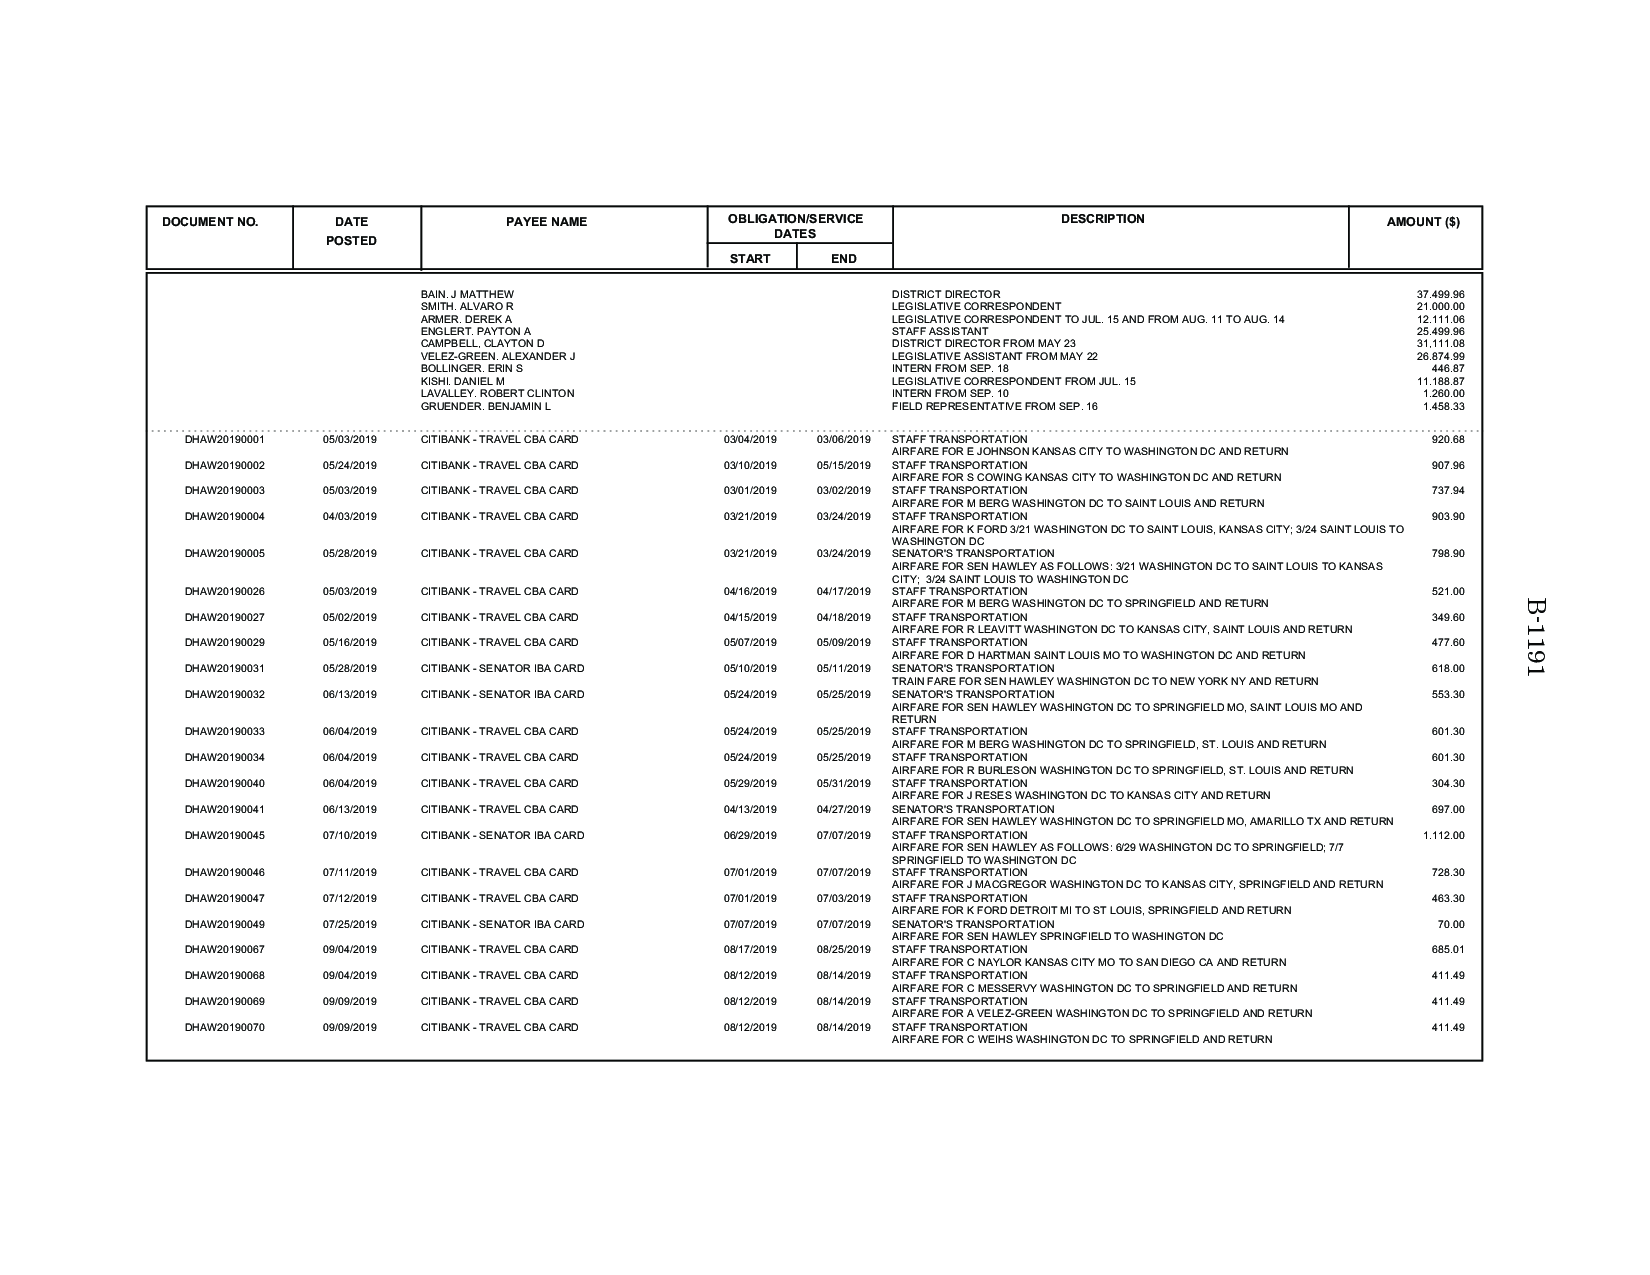

In [200]:
## Start with pdfplumber docs:
## https://github.com/jsvine/pdfplumber#extracting-tables

##  To rotate each page 90 degrees, I first ran: 
##  pdftk 116sdoc10_p1207_1225.pdf cat 1-endeast output 116sdoc10_p1207_1225_rotated.pdf
##

from pdfplumber import pdfplumber
IN_PATH = '116sdoc10_p1207_1225_rotated.pdf'

the_pdf = pdfplumber.open(IN_PATH)
pg = the_pdf.pages[0]
im = pg.to_image(resolution=150)

im

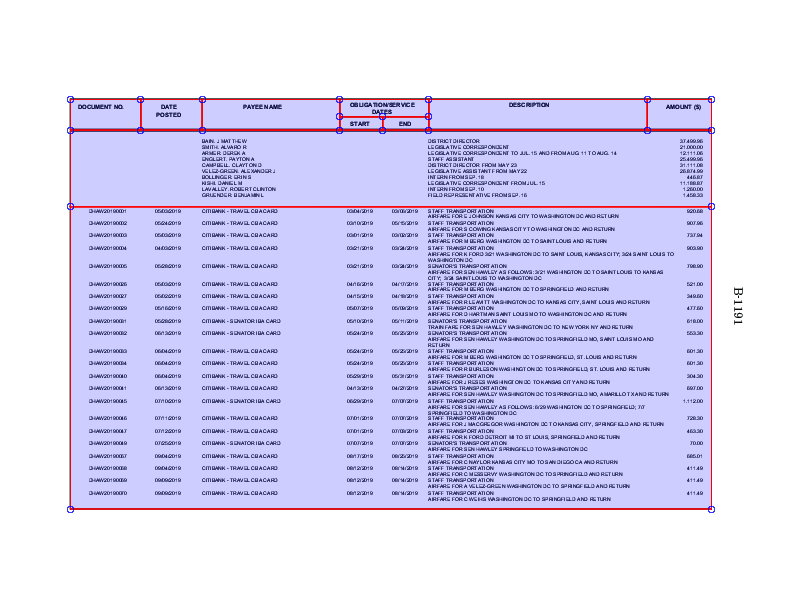

In [5]:
# finding tables with no defaults doesn't work very well. 


pg.to_image().debug_tablefinder()


In [59]:
## Even though the below isn't the table we want, it's still doing useful work
## It's going to be useful to identify the headers later.
## Also note we can plug the bounding box of the first row in for use later

tablesfound = pg.debug_tablefinder()
main_table = tablesfound.tables[0]

# Get the bounding box of the first row
top_region_bbox = main_table.rows[0].bbox

# I wasn't sure of the var name, I found it with this
# I could've read the docs too
# main_table.rows[0].__dict__

# Print the first row with this
pg.crop(top_region_bbox).to_image()


## IMPORTANT - THIS IS A DEMO, TO DO THIS FOR REAL YOU'D WANT TO 
## VERIFY THAT THIS WORKED ON EVERY PAGE, NOT JUST THIS ONE
## THIS IS FROM A 3000-PAGE PDF, IT'S NOT AS TRIVIAL AS IT SOUNDS



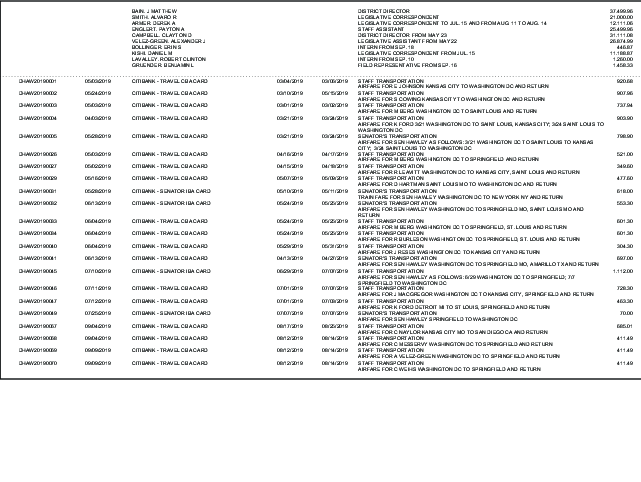

In [60]:
# The bbox is (x0, y0, x1, y1)
# so we could print the rest of the page with

pg.crop((top_region_bbox[0], top_region_bbox[3],top_region_bbox[2],pg.height)).to_image()

# This *is* the region we want to extract data from. We'll return to this in a bit. 

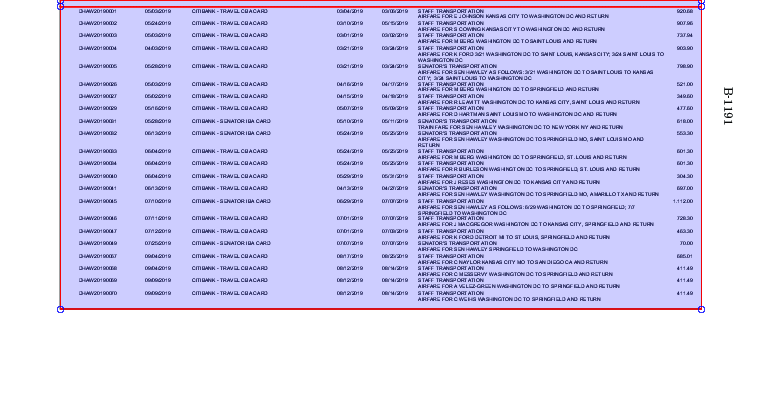

In [12]:
## Is it just a matter of cropping... not really

px = pg.crop((10, 200, pg.width, pg.height))
px.to_image().debug_tablefinder()

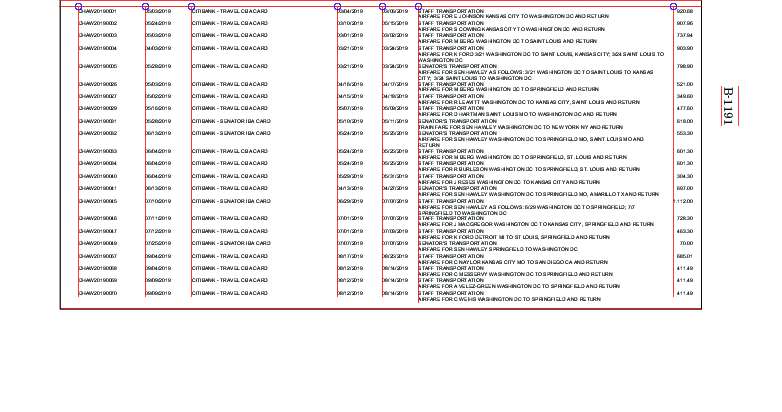

In [13]:
# From table.py source
# https://github.com/jsvine/pdfplumber/blob/master/pdfplumber/table.py#L391
# TABLE_STRATEGIES = [ "lines", "lines_strict", "text", "explicit" ]
# DEFAULT_TABLE_SETTINGS = {
#     "vertical_strategy": "lines",
#     "horizontal_strategy": "lines",
#     "explicit_vertical_lines": [],
#     "explicit_horizontal_lines": [],
#     "snap_tolerance": DEFAULT_SNAP_TOLERANCE,
#     "join_tolerance": DEFAULT_JOIN_TOLERANCE,
#     "edge_min_length": 3,
#     "min_words_vertical": DEFAULT_MIN_WORDS_VERTICAL,
#     "min_words_horizontal": DEFAULT_MIN_WORDS_HORIZONTAL,
#     "keep_blank_chars": False,
#     "text_tolerance": 3,
#     "text_x_tolerance": None,
#     "text_y_tolerance": None,
#     "intersection_tolerance": 3,
#     "intersection_x_tolerance": None,
#     "intersection_y_tolerance": None,
# }

config = {
    'vertical_strategy':'text',
}

px.to_image().debug_tablefinder(config)



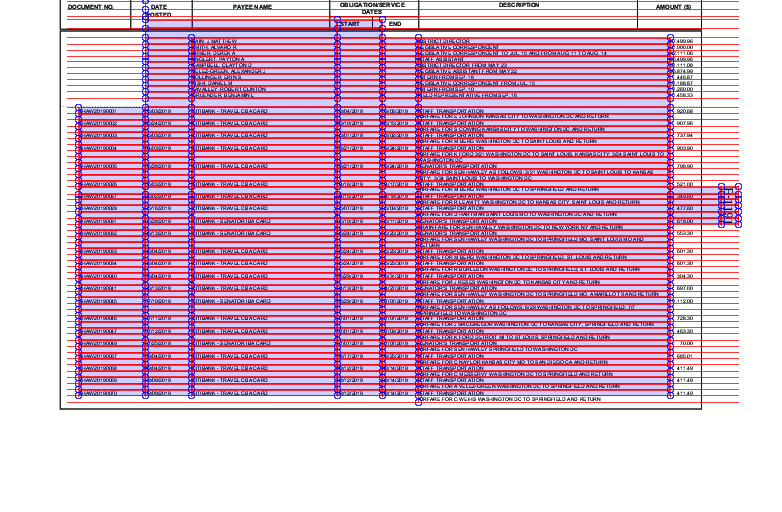

In [15]:
px = pg.crop((10, 100, pg.width, pg.height))

config = {
    'vertical_strategy':'text',
    'horizontal_strategy':'text',
}

px.to_image().debug_tablefinder(config)

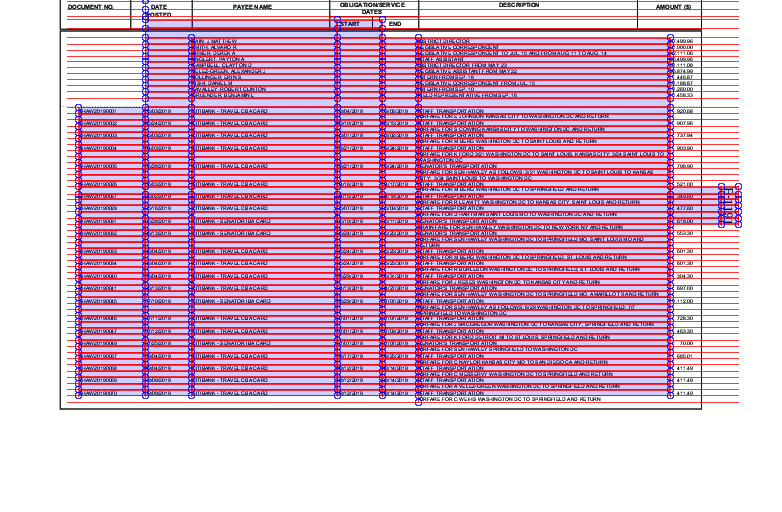

In [16]:
px = pg.crop((10, 100, pg.width, pg.height))

config = {
    'vertical_strategy':'text',
    'horizontal_strategy':'text',
    'keep_blank_chars':True
}

px.to_image().debug_tablefinder(config)
#     "keep_blank_chars": False,


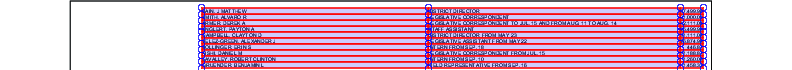

In [28]:
## We can do an ok job with some of it if we are precise enough

px = pg.crop((0, 130, pg.width, 200))

config = {
    'vertical_strategy':'text',
    'horizontal_strategy':'text',
    'keep_blank_chars':True
}

px.to_image().debug_tablefinder(config)
#     "keep_blank_chars": False,

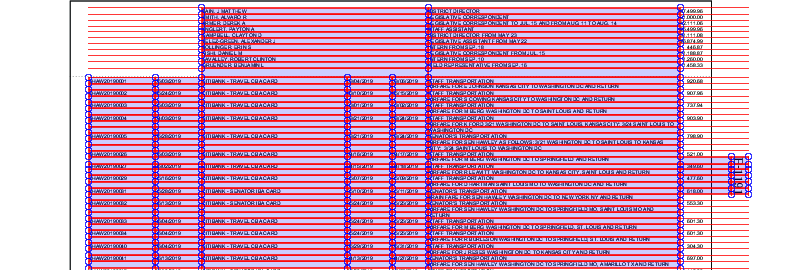

In [29]:
## But it gets messy

px = pg.crop((0, 130, pg.width, 400))

config = {
    'vertical_strategy':'text',
    'horizontal_strategy':'text',
    'keep_blank_chars':True
}

px.to_image().debug_tablefinder(config)
#     "keep_blank_chars": False,

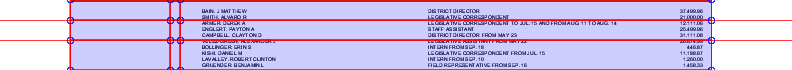

In [34]:
## What if we just tell it where the lines should be? 

px = pg.crop((0, 130, pg.width, 200))

config = {
    #'vertical_strategy':'text',  
    #'horizontal_strategy':'text',
    'keep_blank_chars':True,
    'explicit_vertical_lines': [170,180],
    'explicit_horizontal_lines': [150,170]
    
    
}

px.to_image().debug_tablefinder(config)
#     "keep_blank_chars": False,



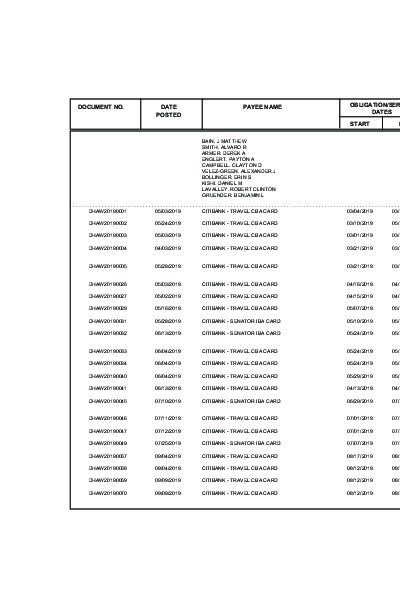

In [36]:
## Even though this seems harder, if we can just figure out where rows / columns
## start and end we will be in business, kinda

## Looking at the table it seems like each new payee would be a way to divide this up.

## Earlier we found just the header section, can we identify the column where payees are? 
## If we identify the payees column, then the location of each new payee
## then we feed those values back in as explicit lines. 
## If this seems convoluted, try doing this with pandas greater-than less-than selectors... 




In [67]:
# earlier on we were able to isolate the "top" of the page, we can actually isolate
# where payees by using the third cell

payee_header_region = main_table.rows[0].cells[2]

pg.crop(payee_header_region).to_image()

In [68]:
# The bbox is (x0, y0, x1, y1)
payee_header_region

(Decimal('202.247'), Decimal('99.107'), Decimal('339.659'), Decimal('130.070'))

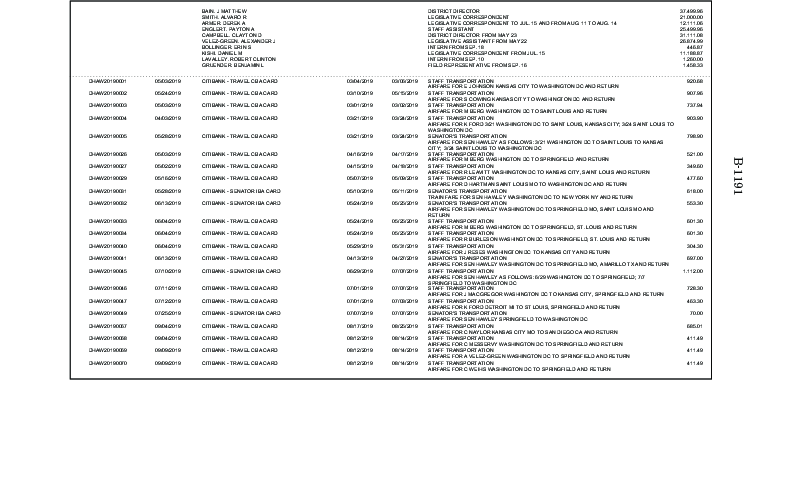

In [99]:
# Ok so we want to isolate the part of the page that's under *just* the payees header

under_payees_region = (payee_header_region[0],payee_header_region[3],payee_header_region[2],pg.height)
under_headers_region = (0,payee_header_region[3],pg.width,pg.height)

pg.crop(under_payees_region).to_image()
#pg.crop(under_headers_region).to_image()

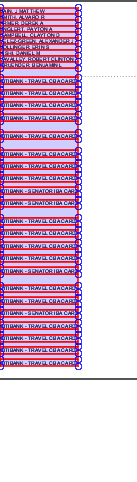

In [109]:


config = {
    'vertical_strategy':'text',
    'horizontal_strategy':'text',

}


pg.crop(under_payees_region).to_image().debug_tablefinder(config)

In [169]:
## Not bad! The next step is to extract just the tops of these cells. 
## But note that we want to skipp the empty 

# extract the debugging info
tablesfound_debug = pg.crop(under_payees_region).debug_tablefinder(config)

# extract the tables that go with it
tables = pg.crop(under_payees_region).extract_tables(config)

print("num tables found %s" % len(tables))

y_values = []
for j, row in enumerate(tablesfound_debug.tables[0].rows):
    ytop = row.cells[0][1]
    
    # This is the value of the corresponding cell, because each column
    # has one item we know it's the first one
    cell_value = tables[0][j][0]
    if cell_value:
        y_values.append(ytop)
        
print("Y separators are %s" % y_values)

## 

num tables found 1
Y separators are [Decimal('137.581'), Decimal('144.058'), Decimal('150.031'), Decimal('156.004'), Decimal('161.977'), Decimal('167.950'), Decimal('173.922'), Decimal('179.895'), Decimal('185.868'), Decimal('191.841'), Decimal('207.202'), Decimal('219.588'), Decimal('231.973'), Decimal('244.358'), Decimal('262.277'), Decimal('280.195'), Decimal('292.581'), Decimal('304.966'), Decimal('317.351'), Decimal('329.737'), Decimal('347.655'), Decimal('360.040'), Decimal('372.426'), Decimal('384.811'), Decimal('397.196'), Decimal('415.115'), Decimal('427.500'), Decimal('439.885'), Decimal('452.271'), Decimal('464.656'), Decimal('477.042')]


In [165]:
# Now using the header from earlier, find the column separators.


# x0 y0 x1 y1 
main_table.rows[0].cells[0]
line_breaks = []
line_breaks.append(main_table.rows[0].cells[0][0])

for cell in main_table.rows[0].cells:
    print(cell)
    if cell:
        line_breaks.append(cell[2])
    else:
        print('skipping')
#print("breaks are %s" % line_breaks)

(Decimal('70.332'), Decimal('99.107'), Decimal('140.687'), Decimal('130.070'))
(Decimal('140.687'), Decimal('99.107'), Decimal('202.247'), Decimal('130.070'))
(Decimal('202.247'), Decimal('99.107'), Decimal('339.659'), Decimal('130.070'))
(Decimal('339.659'), Decimal('99.107'), Decimal('428.701'), Decimal('116.695'))
None
skipping
(Decimal('428.701'), Decimal('99.107'), Decimal('647.460'), Decimal('130.070'))
(Decimal('647.460'), Decimal('99.107'), Decimal('711.585'), Decimal('130.070'))


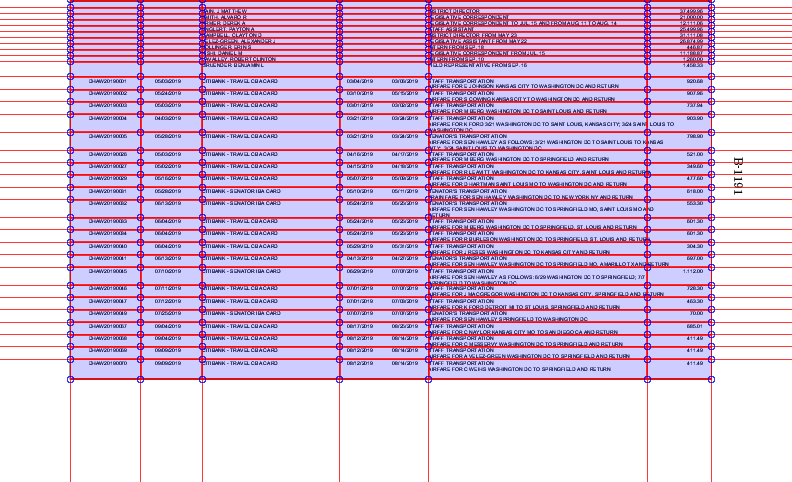

In [166]:

config = {
       'explicit_vertical_lines': line_breaks,
        'explicit_horizontal_lines': y_values
}


pg.crop(under_headers_region).to_image().debug_tablefinder(config)


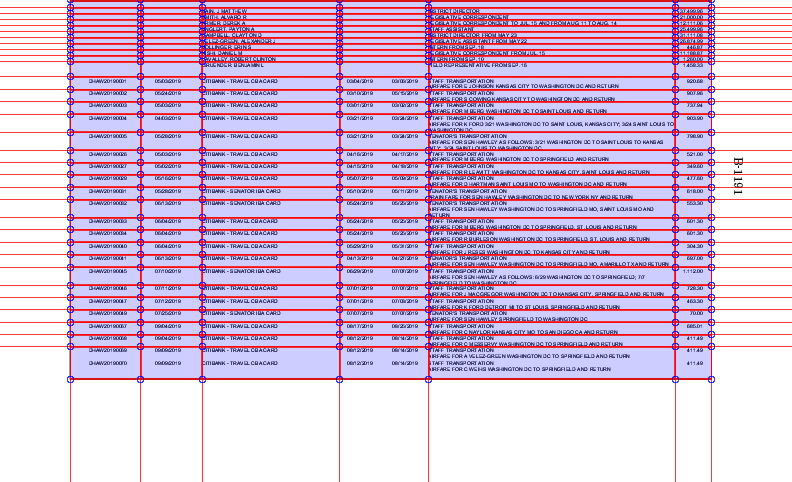

In [196]:
# This is almost right! But note that the right column
# is a little off, if you look at the whole image
# they don't respect the lines
line_breaks[5] = 675 # 

# That's kinda a dangerous hack we don't know how well it works

config = {
        'explicit_vertical_lines': line_breaks,
        'explicit_horizontal_lines': y_values,
        'text_tolerance': 1,
        'text_x_tolerance': 1,
        'text_y_tolerance': 1,
        'keep_blank_chars':True,
}

pg.crop(under_headers_region).to_image().debug_tablefinder(config)



In [197]:
import csv

result = pg.crop(under_headers_region).extract_tables(config)


outputwriter = csv.writer(open("senateoutput1.csv", 'w'))

for row in result[0]:
    print(row)
    outputwriter.writerow(row)

['', '', '', '', '', '']
['', '', 'BAIN,JMATTHEW', '', 'DISTRICTDIRECTOR', '37,499.96']
['', '', 'SMITH,ALVAROR', '', 'LEGISLATIVECORRESPONDENT', '21,000.00']
['', '', 'ARMER,DEREKA', '', 'LEGISLATIVECORRESPONDENTTOJUL.15ANDFROMAUG.11TOAUG.14', '12,111.06']
['', '', 'ENGLERT,PAYTONA', '', 'STAFFASSISTANT', '25,499.96']
['', '', 'CAMPBELL,CLAYTOND', '', 'DISTRICTDIRECTORFROMMAY23', '31,111.08']
['', '', 'VELEZ-GREEN,ALEXANDERJ', '', 'LEGISLATIVEASSISTANTFROMMAY22', '26,874.99']
['', '', 'BOLLINGER,ERINS', '', 'INTERNFROMSEP.18', '446.87']
['', '', 'KISHI,DANIELM', '', 'LEGISLATIVECORRESPONDENTFROMJUL.15', '11,188.87']
['', '', 'LAVALLEY,ROBERTCLINTON', '', 'INTERNFROMSEP.10', '1,260.00']
['', '', 'GRUENDER,BENJAMINL', '', 'FIELDREPRESENTATIVEFROMSEP.16', '1,458.33']
['DHAW20190001', '05/03/2019', 'CITIBANK-TRAVELCBACARD', '03/04/2019 03/06/2019', 'STAFFTRANSPORTATION\nAIRFAREFOREJOHNSONKANSASCITYTOWASHINGTONDCANDRETURN', '920.68']
['DHAW20190002', '05/24/2019', 'CITIBANK-TRAVELCBACARD',

In [195]:
# It's a bit unclear why the words are getting extracted like that? 

words = pg.crop(under_headers_region).extract_words(x_tolerance=1, y_tolerance=1)
words

[{'x0': Decimal('201.881'),
  'x1': Decimal('215.275'),
  'top': Decimal('137.581'),
  'bottom': Decimal('144.563'),
  'text': 'BAIN,'},
 {'x0': Decimal('216.706'),
  'x1': Decimal('219.271'),
  'top': Decimal('137.581'),
  'bottom': Decimal('144.563'),
  'text': 'J'},
 {'x0': Decimal('220.692'),
  'x1': Decimal('246.618'),
  'top': Decimal('137.581'),
  'bottom': Decimal('144.563'),
  'text': 'MATTHEW'},
 {'x0': Decimal('428.335'),
  'x1': Decimal('451.991'),
  'top': Decimal('137.581'),
  'bottom': Decimal('144.563'),
  'text': 'DISTRICT'},
 {'x0': Decimal('453.418'),
  'x1': Decimal('480.215'),
  'top': Decimal('137.581'),
  'bottom': Decimal('144.563'),
  'text': 'DIRECTOR'},
 {'x0': Decimal('680.285'),
  'x1': Decimal('703.111'),
  'top': Decimal('137.581'),
  'bottom': Decimal('144.563'),
  'text': '37,499.96'},
 {'x0': Decimal('201.881'),
  'x1': Decimal('219.260'),
  'top': Decimal('143.553'),
  'bottom': Decimal('150.535'),
  'text': 'SMITH,'},
 {'x0': Decimal('220.692'),
  'x